In [16]:
import pandas as pd
import numpy as np

import re

import nltk
nltk.download('wordnet')

from nltk.stem import WordNetLemmatizer

import string

import cv2

import csv

from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\20190735\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\20190735\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\20190735\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\omw-1.4.zip.


True

# Loading & Combining

In [38]:
df_logins = pd.read_csv('data/txt_login.csv')
df_logins

,ImageName,Text,Target
0,0436b98309bf07065a2a2da8ad7e1335.png,CleanMyCar India's first waterless car cleani...,1
1,1920x1080_UI-builder.jpg,New page Choose the page type you'd like to u...,1
2,1_Login_anatomy_1120.png,18M [Product Name} r Login Don’t have an ac...,1
3,46586789.jpg,Welcome Back! a Siete pixtastock.com - 46586...,1
4,6181093387__Web.png,Custom Login Page Company Name Custom Login ...,1
...,...,...,...
174,tue.png,x @ Signi x [BM Reden x | @ localh x | ( Front...,1
175,website-user-login-page-template-design-vector...,Password EZ Remember me Forgot Password?,1
176,wordpress-custom-login-page.png,TUTORIAL How to Make a WordPress Custom Login...,1
177,wordpress-default-login-.png,Username or Email Address Password (_) Remem...,1


In [37]:
df_random = pd.read_csv('data/txt_random.csv')
df_random

,ImageName,Text,Target
0,Screenshot 2022-06-13 150908.png,® Nee x | @ Signi x | MM Reden x | @ localh x ...,0
1,Screenshot 2022-06-13 150954.png,* Nee x | @ Sign x | f Reden x | @ localh x | ...,0
2,Screenshot 2022-06-13 151006.png,® iNee x | @ Signi x | MM Reden x | @ localh x...,0
3,Screenshot 2022-06-13 151031.png,> (429) x = @ Signi x | GM Reden x | @ localh ...,0
4,Screenshot 2022-06-13 151101.png,Yourr x @ Sign) x | QJ Reden x | @ localh x | ...,0
5,Screenshot 2022-06-13 151133.png,x a SeP_ti YourPr x {@ Desmo x xX | @ localh...,0
6,Screenshot 2022-06-13 151257.png,"Ge x hi © Fronter x Timest @ fmis.tue.nl, ® ...",0
7,Screenshot 2022-06-13 151319.png,"x, Diction x ff Redem; x | @ localho x | (> Fr...",0
8,Screenshot 2022-06-13 151342.png,Your P: x [Bi Redem x | @ hi Timesh x detexif...,0
9,Screenshot 2022-06-13 151403.png,Your P My Dr BB Reder h @ Fronter x Timesh: x ...,0


In [73]:
df_creditcard = pd.read_csv('data/txt_creditcard.csv')
df_creditcard.head()

,ImageName,Text,Target
0,1_d_c88-7udwldiF6oq61uPQ.png,Pay Invoice visa @D Payment amount $500.00 e...,2
1,ae.png,(QM MAKE SURE YOU CHECK OUT THE CHANGES TO YOU...,2
2,amazon.png,[+] Card number Amazon accepts all major cred...,2
3,asos.jpg,“The following errors have occurred: ‘= the c...,2
4,credit-card-form.png,Confirm Purchase Owner cw Card Number Expira...,2


In [74]:
def combine_dfs(dfs):
    return pd.concat(dfs, ignore_index=True)

# Preprocessing

In [75]:
lemmatizer = WordNetLemmatizer()

def preprocess(text):
    text = [i.split('\n') for i in text.split(' ')]
    text = [item for sublist in text for item in sublist]
    text = [i for i in text if i not in stopwords.words('english')]
    text = ' '.join(text)
    text = text.lower() 
    text = text.strip()  
    text = re.compile('<.*?>').sub('', text) 
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)  
    text = re.sub('\s+', ' ', text)  
    text = re.sub(r'\[[0-9]*\]',' ',text) 
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
    text = re.sub(r'\d',' ',text) 
    text = re.sub(r'\s+',' ',text)
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)
    text = re.sub(r'\^[a-zA-Z]\s+', ' ', text)
    text = re.sub(r'\s+', ' ', text, flags=re.I)
    
    # Lemmatize
    text = [lemmatizer.lemmatize(word) for word in text.split()]
    text = ' '.join([i for i in text if len(i) > 1])
    
    return text

In [78]:
df_combined = combine_dfs([df_logins, df_random, df_creditcard])
df_combined['TextPreprocessed'] = df_combined['Text'].apply(lambda x: preprocess(x))
df_combined

,ImageName,Text,Target,TextPreprocessed
0,0436b98309bf07065a2a2da8ad7e1335.png,CleanMyCar India's first waterless car cleani...,1,cleanmycar india first waterless car cleaning ...
1,1920x1080_UI-builder.jpg,New page Choose the page type you'd like to u...,1,new page choose page type like use utbuilder s...
2,1_Login_anatomy_1120.png,18M [Product Name} r Login Don’t have an ac...,1,product name login dont account remember
3,46586789.jpg,Welcome Back! a Siete pixtastock.com - 46586...,1,welcome back siete pixtastock com
4,6181093387__Web.png,Custom Login Page Company Name Custom Login ...,1,custom login page company name custom login us...
...,...,...,...,...
260,Screenshot 2022-06-13 163656.png,@ con x | © poe x @ coolblue.nl x es x @ ...,2,con poe coolblue nl fro git key pay tt payment...
261,update-cc2.png,Update Credit Card Card Number: Expiration Dat...,2,update credit card card number expiration date...
262,zara1.png,ENTER YOUR CARD DETAILS VISA CARD NUMBER CA...,2,enter your card detail visa card number card h...
263,zara2.png,ENTER YOUR CARD DETAILS CARD NUMBER CARD HOL...,2,enter your card detail card number card holder...


In [79]:
texts_comb = df_combined['TextPreprocessed']
y_comb = df_combined['Target']

# Classifier

In [55]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import plot_confusion_matrix

In [70]:
def train_random_forest(texts, y):
    vectorizer = CountVectorizer(max_features=1500, min_df=5, max_df=0.7, stop_words=stopwords.words('english'))
    X = vectorizer.fit_transform(texts).toarray()
    tfidfconverter = TfidfTransformer()
    X = tfidfconverter.fit_transform(X).toarray()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    classifier = RandomForestClassifier(n_estimators=1000, random_state=0)
    classifier.fit(X_train, y_train) 
    y_pred = classifier.predict(X_test)
    plot_confusion_matrix(classifier, X_test, y_test)  
    print(classification_report(y_test,y_pred))
    print(accuracy_score(y_test, y_pred))
    return classifier

              precision    recall  f1-score   support

           0       0.75      0.82      0.78        11
           1       0.92      0.95      0.93        37
           2       1.00      0.60      0.75         5

    accuracy                           0.89        53
   macro avg       0.89      0.79      0.82        53
weighted avg       0.89      0.89      0.88        53

0.8867924528301887


C:\Users\20190735\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


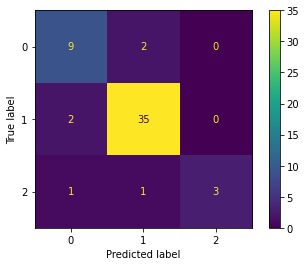

In [80]:
classifier_comb = train_random_forest(texts_comb, y_comb)